In [2]:

import transformers

In [3]:
from transformers import DetrImageProcessor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
from transformers import DetrForObjectDetection

In [5]:
MODEL_PATH = '/home/congtt/hieu/trainclasss/custom-model'
# model.model.save_pretrained(MODEL_PATH)

# loading model
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
DEVICE = 'cuda:0'  # Sử dụng GPU đầu tiên
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [6]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [7]:

import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

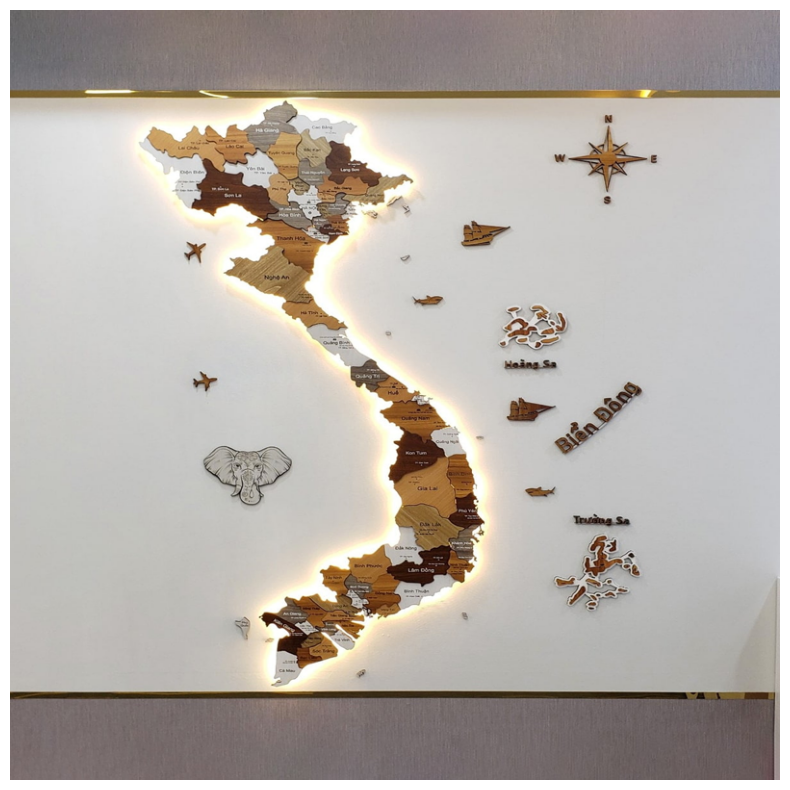

In [17]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Đường dẫn đến ảnh của bạn
image_path = '/home/congtt/hieu/anh test/Image-ban-do-go-2-.jpg'

# Load ảnh và điều chỉnh kích thước
input_size = (800, 800)
image = Image.open(image_path).resize(input_size)

# Chuyển đổi ảnh thành tensor và chuẩn hóa
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image)

# Thêm một chiều batch (batch dimension)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to(DEVICE)

# Dự đoán bounding box và nhãn
with torch.no_grad():
    outputs = model(pixel_values=image_tensor, pixel_mask=None)

# Trích xuất kết quả dự đoán
postprocessed_outputs = image_processor.post_process_object_detection(outputs, target_sizes=[input_size], threshold=0.9)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])
